In [7]:
import random
import numpy as np
import cPickle
import gzip
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'cPickle'

In [ ]:
#Data loader and wrapper by "mnielsen" https://github.com/mnielsen/neural-networks-and-deep-learning

def load_data():
    '''Loading the mnist dataset from an archive'''
    f = gzip.open('./mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = cPickle.load(f)
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    '''Reshaping the data in a tuple with on one hand the greyscale image and on the other the the label (between 0-9)'''
    tr_d, va_d, te_d = load_data()
    
    #Organizing the training set
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    
    #Organizing the validation set
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    
    #Organizing the testing set 
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    '''Vectorizing the output with 1 at the true label and zeroes everywhere else'''
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [3]:
#Loading data
training_data, validation_data, test_data = load_data_wrapper()

NameError: name 'load_data_wrapper' is not defined

In [4]:
#Network inspired by "mnielsen" https://github.com/mnielsen/neural-networks-and-deep-learning
class Network(object):
    def __init__(self, sizes,p=0.5):
        '''For initialization, sizes is the list of sizes of the layers [input h1 h2 h3 output]
        p is dropout rate'''
        #Initialization 
        #picking a random seed
        np.random.seed(0)
        #avoiding conditionning error in adagrad
        self.eps = np.finfo(np.float).eps
        #storing hyper parameters as attributes
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.p = p
        
        self.dropOut = self.dropOut = [np.array((np.random.rand(y, 1)<self.p),np.float) for y in self.sizes[1:]]
        
        #Initializing weights with low variance gaussians
        #Initializing biases with 0
        self.biases = [np.zeros([y, 1]) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)/5.0
                        for x, y in zip(sizes[:-1], sizes[1:])]

        #Initialization of the softmax layer
        self.weightsSoftMax = np.random.randn(10, sizes[-1])/5.0
        self.biasSoftMax = np.zeros([10,1])
        
        #Initialization of loss lists for plotting
        self.test_lost=[]
        self.test_accuracy=[]
    
    def feedforward(self, a):
        ''''''
        for b, w, dp in zip(self.biases, self.weights, self.dropOut):
            a = tanh(np.dot(w, a)+b)
        a = softmax(np.dot(self.weightsSoftMax,a)+self.biasSoftMax)
        return a 
    
    def feedforwardNoDrop(self, a):
        
        index=0
        for b, w in zip(self.biases, self.weights):
            if index == 0:
                a = tanh(np.dot(w, a)+b)
            else:
                a = tanh(np.dot(w, a)+b)*p
        a = softmax(np.dot(self.weightsSoftMax,a)+self.biasSoftMax)
        return a 
    
       
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, regularization,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.dropOut = [np.array((np.random.rand(y, 1)<self.p),np.float) for y in self.sizes[1:]]
                self.update_mini_batch(mini_batch, eta, regularization)
            if test_data:
                print "Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test)
            else:
                print "Epoch {0} complete".format(j)

    def update_mini_batch(self, mini_batch, eta, regularization):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        nabla_b_SM = np.zeros_like(self.biasSoftMax)
        nabla_w_SM = np.zeros_like(self.weightsSoftMax)
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w, delta_b_SM, delta_w_SM = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            nabla_b_SM = nabla_b_SM + delta_b_SM
            nabla_w_SM = nabla_w_SM + delta_w_SM
        self.weights = [w*(1-regularization*eta/len(w))-(eta/len(mini_batch))*nw 
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]
        self.weightsSoftMax = self.weightsSoftMax*(1-eta*regularization/len(w)) - (eta/len(mini_batch))*nabla_w_SM 
        self.biasSoftMax -= (eta/len(mini_batch))*nabla_b_SM

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        nabla_bSM = np.zeros_like(self.biasSoftMax)
        nabla_wSM = np.zeros_like(self.weightsSoftMax)
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs=[]
        index=0
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = tanh(z)*self.dropOut[index]
            activations.append(activation)
            index += 1
        z = (np.dot(self.weightsSoftMax, activation)+self.biasSoftMax)
        zs.append(z) # list to store all the z vectors, layer by layer
        activation = tanh(z)
        activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1],y)
        nabla_bSM = delta
        nabla_wSM = np.dot(delta, activations[-2].transpose())
        delta = np.dot(self.weightsSoftMax.transpose(), delta)*tanh_prime(zs[-2]) *self.dropOut[-1]
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-3].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in xrange(2, self.num_layers):
            delta = np.dot(self.weights[-l+1].transpose(), delta) * tanh_prime(zs[-l-1])*self.dropOut[-l]
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-2].transpose())
        return (nabla_b, nabla_w, nabla_bSM, nabla_wSM)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforwardNoDrop(x)), y)
                        for (x, y) in test_data]
        self.test_accuracy.append(sum(int(x == y) for (x, y) in test_results))
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations - y)
    
    def cost_function(self, test_data):
        a=[np.sum(0.5*(self.feedforward(x)-1*(range(0,10)==y))**2) for (x, y) in test_data]
        return sum(a)

#### Miscellaneous functions
def tanh(z):
    """The tanh function."""
    a= np.copy(z)
    a[z<=0] = 0
    return a

def tanh_prime(z):
    """Derivative of the tanh function."""
    a= np.zeros_like(z)
    a[z>0] = 1
    return a

def softmax(x):
    """Compute the softmax of vector x."""
    exps = np.exp(x - x.max())
    return exps / np.sum(exps)

SyntaxError: invalid syntax (<ipython-input-4-3dd2443161a1>, line 73)

In [1]:
Net4=Network([784,50,30],p=0.5)

NameError: name 'Network' is not defined

In [32]:
Net4.SGD(training_data,20,10,0.10,0.0,test_data=test_data)

Epoch 0: 7240 / 10000
Epoch 1: 8269 / 10000
Epoch 2: 8469 / 10000
Epoch 3: 8648 / 10000
Epoch 4: 9011 / 10000
Epoch 5: 9120 / 10000
Epoch 6: 9146 / 10000
Epoch 7: 9201 / 10000
Epoch 8: 9216 / 10000
Epoch 9: 9231 / 10000
Epoch 10: 9277 / 10000
Epoch 11: 9270 / 10000
Epoch 12: 9316 / 10000
Epoch 13: 9279 / 10000
Epoch 14: 9263 / 10000
Epoch 15: 9309 / 10000
Epoch 16: 9301 / 10000
Epoch 17: 9336 / 10000
Epoch 18: 9361 / 10000
Epoch 19: 9350 / 10000
Epoch 20: 9350 / 10000
Epoch 21: 9335 / 10000
Epoch 22: 9333 / 10000
Epoch 23: 9355 / 10000
Epoch 24: 9362 / 10000


KeyboardInterrupt: 

In [15]:
Net2=Network([784,50,30],p=1)
Net2.SGD(training_data,10,10,0.10,0.05,test_data=test_data)

Epoch 0: 9339 / 10000
Epoch 1: 9503 / 10000
Epoch 2: 9598 / 10000
Epoch 3: 9617 / 10000
Epoch 4: 9617 / 10000
Epoch 5: 9694 / 10000
Epoch 6: 9664 / 10000
Epoch 7: 9672 / 10000
Epoch 8: 9703 / 10000
Epoch 9: 9729 / 10000


In [16]:
Net3=Network([784,50,30],p=1)
Net3.SGD(training_data,10,10,0.15,0.0,test_data=test_data)

Epoch 0: 9317 / 10000
Epoch 1: 9448 / 10000
Epoch 2: 9507 / 10000
Epoch 3: 9545 / 10000
Epoch 4: 9575 / 10000
Epoch 5: 9621 / 10000
Epoch 6: 9617 / 10000
Epoch 7: 9604 / 10000
Epoch 8: 9611 / 10000
Epoch 9: 9639 / 10000


In [ ]:
plt.plot(Net.test_lost)
plt.plot(Net2.test_lost)
plt.show()

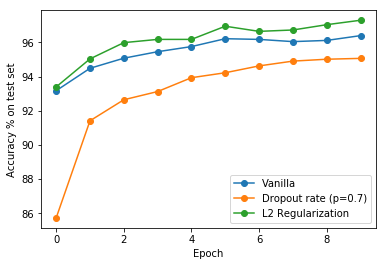

In [28]:
plt.plot(np.array(Net3.test_accuracy)*(1/100.0),'o-',label='Vanilla')
plt.plot(np.array(Net.test_accuracy)*(1/100.0),'o-',label='Dropout rate (p=0.7)')
plt.plot(np.array(Net2.test_accuracy)*(1/100.0),'o-',label='L2 Regularization')
plt.xlabel('Epoch')
plt.ylabel('Accuracy % on test set')
plt.legend()
plt.savefig('regularization.png',dpi=300)
plt.show()

In [318]:
Net.feedforward(test_data[0][0])

array([[ 0.079504  ],
       [ 0.01489715],
       [ 0.14786687],
       [ 0.0123601 ],
       [ 0.06376704],
       [ 0.00883957],
       [ 0.03666194],
       [ 0.12975522],
       [ 0.03382194],
       [ 0.47252617]])

In [316]:
Net.dropOut

[array([[ 0.],
        [ 1.],
        [ 1.],
        [ 0.],
        [ 0.],
        [ 1.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 0.],
        [ 1.],
        [ 0.],
        [ 0.],
        [ 1.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 1.],
        [ 0.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 0.],
        [ 0.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 0.],
        [ 1.],
        [ 1.],
        [ 0.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 1.],
        [ 0.],
        [ 0.]]), array([[ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 0.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 1.],
        [ 0.],
        [